In [1]:
from rdkit import Chem
import re

[19:44:54] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [19:44:54] Enabling RDKit 2019.09.3 jupyter extensions


In [80]:
X = open("../processed_data/train_sources").readlines()
X = list(map(lambda x: re.search("<[^>]*> ([^\n]*)", x).groups()[0], X))
X = list(map(lambda x: "".join(x.split(" ")), X))

Y = open("../processed_data/train_targets").readlines()
Y = list(map(lambda x: x.split('\n')[0], Y))
Y = list(map(lambda x: "".join(x.split(" ")), Y))

In [81]:
X[0], Y[0]

('O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1',
 'CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)cc1Cl')

In [82]:
Y[0] = Y[0].split(".")[1]
X[0], Y[0]

('O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1',
 'Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)cc1Cl')

In [83]:
mol1, mol2 = Chem.MolFromSmiles(X[0]), Chem.MolFromSmiles(Y[0])

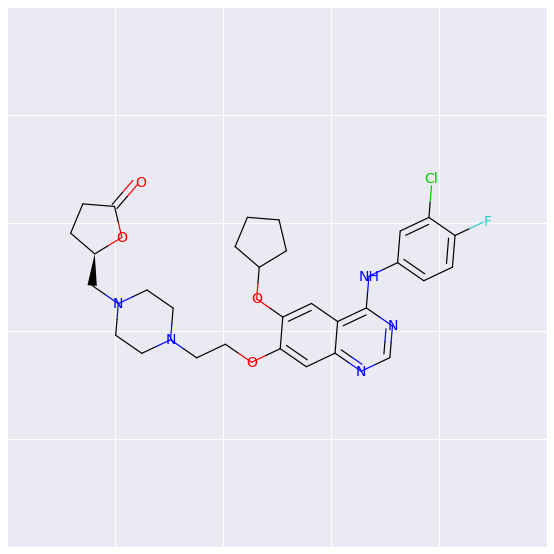

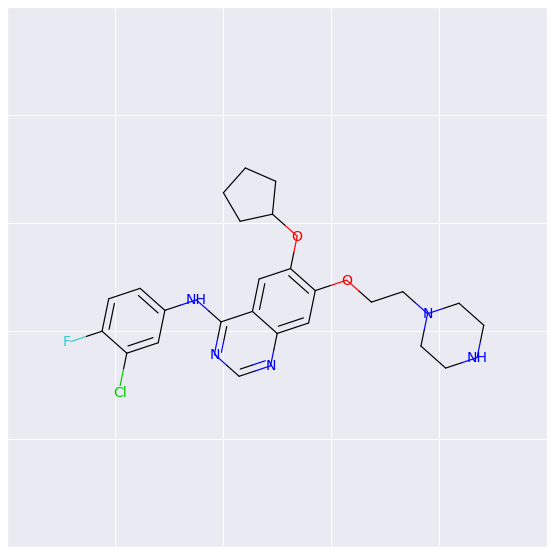

In [84]:
Chem.Draw.MolToMPL(mol1)
Chem.Draw.MolToMPL(mol2)
pass

## Metrics

In [85]:
from rdkit.Chem import Crippen, QED, Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

In [86]:
# logP
print("logP")
print(Crippen.MolLogP(mol1), Crippen.MolLogP(mol2))
print()

# QED
print("QED")
QED_prop = lambda x:   QED.qed(x, QED.properties(x))
print(QED.default(mol1), QED.default(mol2))
print(QED_prop(mol1), QED_prop(mol2))
print()

# Similarity
print("Tanimoto Similarity")
fp1 = FingerprintMols.FingerprintMol(mol1)
fp2 = FingerprintMols.FingerprintMol(mol2)
print(DataStructs.TanimotoSimilarity(fp1, fp2))

logP
5.189300000000004 4.7713000000000045

QED
0.323907392620424 0.4758001774404834
0.09870271175006949 0.2556821411861358

Tanimoto Similarity
0.9004739336492891


# Bulk Metrics

In [87]:
import pandas as pd
import numpy as np

In [88]:
df = pd.DataFrame({"Source": X, "Target": Y})

In [89]:
# replace multiple products with a single product(the largest of the molecules)
def get_biggest_molecule(smile):
    mols = smile.split(".")
    if len(mols) == 1:
        return smile
    lengths = list(map(lambda x: len(x), mols))
    return mols[np.array(lengths).argmax()]

df["Target"] = df["Target"].apply(get_biggest_molecule)

In [90]:
%%time

# add metric columns
df["Source_logP"] = df.apply(lambda row: Crippen.MolLogP(Chem.MolFromSmiles(row["Source"])), axis=1)
df["Target_logP"] = df.apply(lambda row: Crippen.MolLogP(Chem.MolFromSmiles(row["Target"])), axis=1)

df["Source_QED"] = df.apply(lambda row: QED_prop(Chem.MolFromSmiles(row["Source"])), axis=1)
df["Target_QED"] = df.apply(lambda row: QED_prop(Chem.MolFromSmiles(row["Target"])), axis=1)

df["Similarity"] = df.apply(lambda row: DataStructs.TanimotoSimilarity(
                                                        FingerprintMols.FingerprintMol(Chem.MolFromSmiles(row["Source"])), 
                                                        FingerprintMols.FingerprintMol(Chem.MolFromSmiles(row["Target"])) 
                                                        ),
                            axis=1)

CPU times: user 3min 18s, sys: 0 ns, total: 3min 18s
Wall time: 3min 18s


In [91]:
df

,Source,Target,Source_logP,Target_logP,Source_QED,Target_QED,Similarity
0,O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)...,Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)...,5.18930,4.77130,0.098703,0.255682,0.900474
1,Nc1nc2[nH]c(CCCc3csc(C(=O)O)c3)cc2c(=O)[nH]1,COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1,1.76840,1.85680,0.767282,0.812357,0.959777
2,CC1(C)OB(c2cccc(Nc3nccc(C(F)(F)F)n3)c2)OC1(C)C,CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C,3.53820,2.24920,0.811305,0.823860,0.420323
3,CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)O,CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1,1.26840,2.92720,0.786178,0.522256,0.772277
4,Fc1cc2c(NC3CCCCCC3)ncnc2cn1,Fc1cc2c(Cl)ncnc2cn1,3.29860,1.81730,0.867654,0.427316,0.523200
...,...,...,...,...,...,...,...
40024,CCCn1cc(CC)nc1-c1cnc(Nc2ccc(Cl)cc2)c(Cl)c1,CCc1c[nH]c(-c2cnc(Nc3ccc(Cl)cc3)c(Cl)c2)n1,5.96790,5.08450,0.723725,0.934734,0.760083
40025,COc1ccc2nccc(N3C[C@@H]4C[C@H]3CN4CCN)c2n1,COc1ccc2nccc(N3C[C@@H]4C[C@H]3CN4CCNC(=O)OCc3c...,0.86000,2.82770,0.978353,0.444767,0.903683
40026,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4NC4CCN(Cc5c...,CCOC(=O)C1(c2ccc(B3OC(C)(C)C(C)(C)O3)cc2)CC1,6.98822,2.58050,0.145639,0.981474,0.408264
40027,COC(=O)c1ncc(NS(=O)(=O)c2ccncc2)cc1F,COC(=O)c1ncc(Br)cc1F,1.20310,1.76980,0.910556,0.711063,0.531758


## Visualization

In [92]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

sns.set(rc={'figure.figsize':(8, 6)})

(30013, 7)


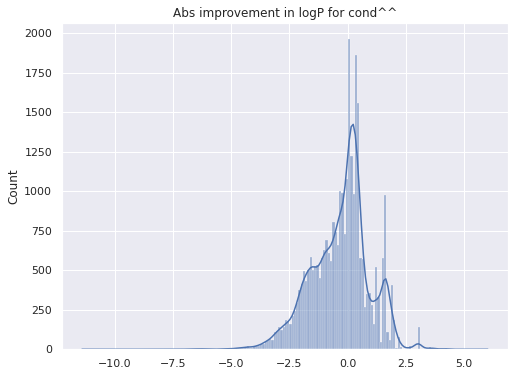

In [93]:
cond = df["Similarity"] > 0.6
cond_df = df[cond]
print(cond_df.shape)

fig = sns.histplot(cond_df["Target_logP"] - cond_df["Source_logP"], kde=True)
fig.set(title="Abs improvement in logP for cond^^")
pass

(30013, 7)


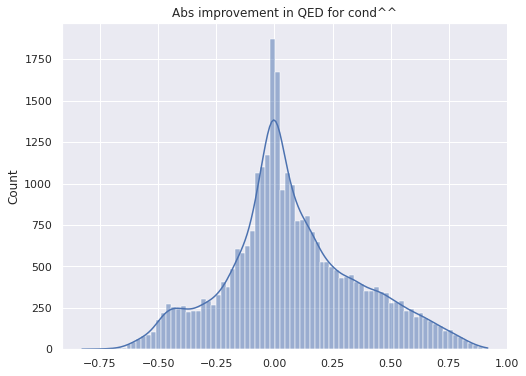

In [94]:
cond = df["Similarity"] > 0.6
cond_df = df[cond]
print(cond_df.shape)

fig = sns.histplot(cond_df["Target_QED"] - cond_df["Source_QED"], kde=True)
fig.set(title="Abs improvement in QED for cond^^")
pass

(16624, 7)


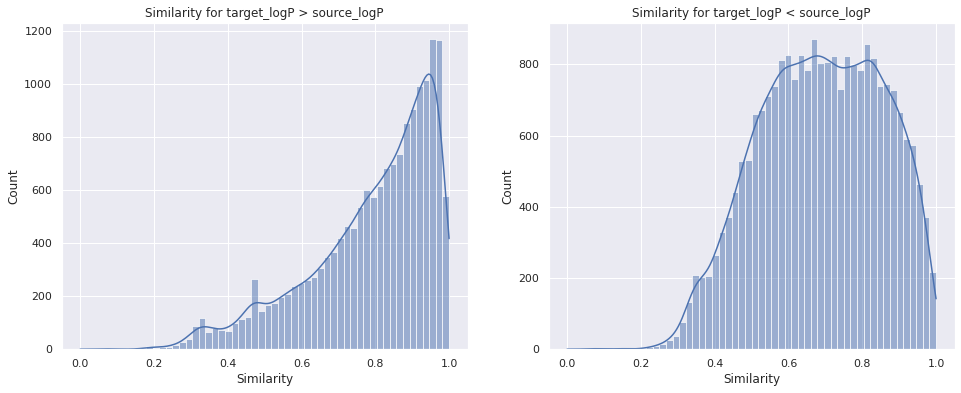

In [95]:
sns.set(rc={'figure.figsize':(16, 6)})

cond = df["Source_logP"] < df["Target_logP"]
cond_df = df[cond]
print(cond_df.shape)

subfig, ax = plt.subplots(1, 2)

fig = sns.histplot(cond_df["Similarity"], kde=True, ax=ax[0])
fig.set(title="Similarity for target_logP > source_logP")

fig = sns.histplot(df[~cond]["Similarity"], kde=True, ax=ax[1])
fig.set(title="Similarity for target_logP < source_logP")
pass

(21530, 7)


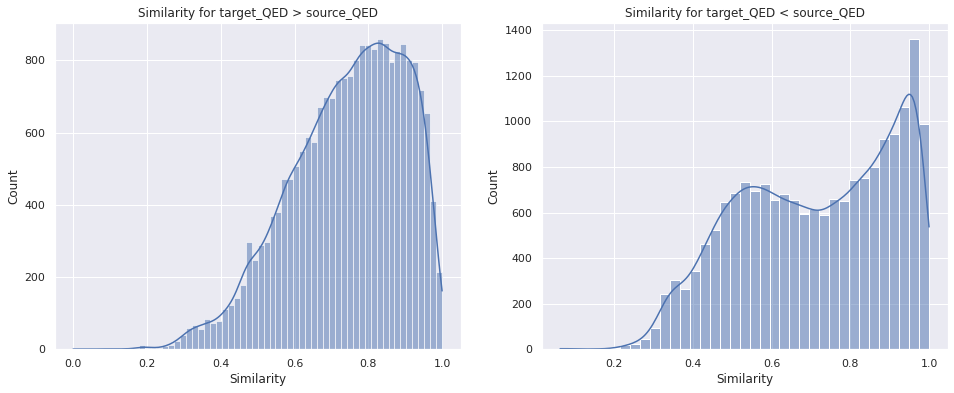

In [96]:
sns.set(rc={'figure.figsize':(16, 6)})

cond = df["Source_QED"] < df["Target_QED"]
cond_df = df[cond]
print(cond_df.shape)

subfig, ax = plt.subplots(1, 2)

fig = sns.histplot(cond_df["Similarity"], kde=True, ax=ax[0])
fig.set(title="Similarity for target_QED > source_QED")

fig = sns.histplot(df[~cond]["Similarity"], kde=True, ax=ax[1])
fig.set(title="Similarity for target_QED < source_QED")
pass